In [2]:
!git clone https://github.com/udacity/CarND-LaneLines-P1.git

fatal: destination path 'CarND-LaneLines-P1' already exists and is not an empty directory.


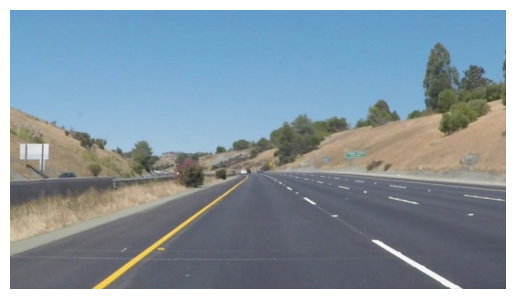

In [3]:
import os
import matplotlib.pyplot as plt
import cv2

path = "/kaggle/working/CarND-LaneLines-P1/test_images"
test_images = os.listdir(path)

# display first test image
image = cv2.imread(os.path.join(path, test_images[0]))
# convert to rgb
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.axis("off")
plt.imshow(image_rgb)
plt.show()

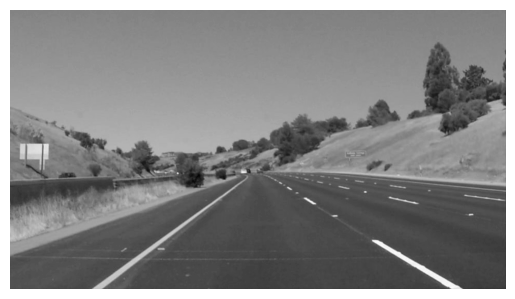

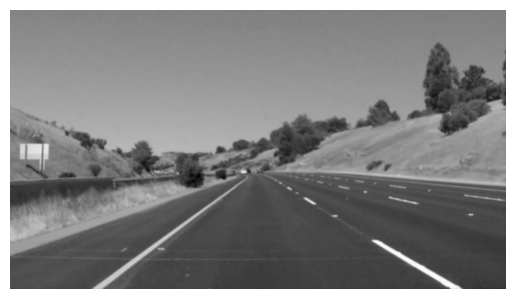

In [4]:
# convert images to grayscale because processing a single channel
# is faster than processing a three-channel colored image
def to_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# reduce noise of image using Gaussian blur to enhance lane lines
def gaussian_blur(image):
    # kernel size of 5x5 provides a good balance between blurring
    # and edge preservation. Last value is standard deviation in X and Y
    # directions
    return cv2.GaussianBlur(image, (5, 5), 0)

# view first test image with grayscale and blur
img_grayscale = to_grayscale(image)
img_blur = gaussian_blur(img_grayscale)
plt.imshow(img_grayscale, cmap="gray")
plt.axis("off")
plt.show()
plt.imshow(img_blur, cmap="gray")
plt.axis("off")
plt.show()

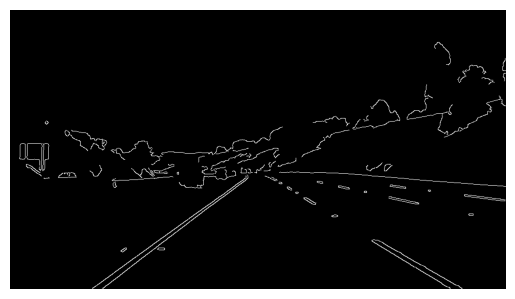

In [5]:
# detect edges using canny edge detection
def canny_edge(image):
    # pass lower and upper thresholds for pixels with gradient magnitudes
    # to be detected as edges: white lines, or not edges: black.
    return cv2.Canny(image, 85, 170)
    
# view first test image with canny edge detection
edges = canny_edge(img_blur)
plt.axis("off")
plt.imshow(edges, cmap="gray")
plt.show()

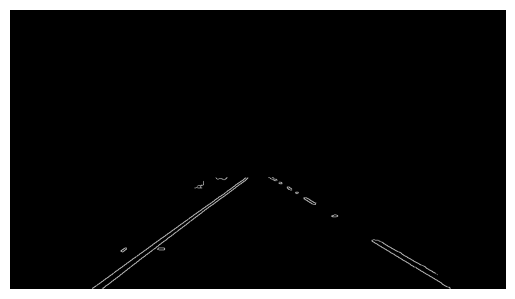

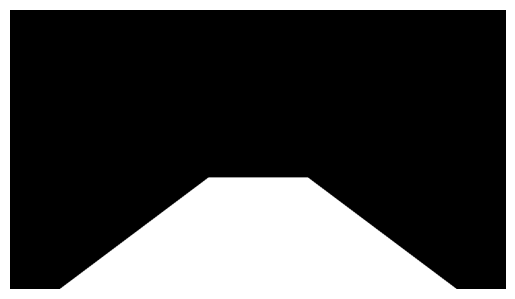

In [6]:
import numpy as np

# find region of interest (residing lane) by masking the region
# and using the bitwise AND operator to find the lane marks
def mask_image(image):
    mask = np.zeros_like(image)   
    # color of mask: white
    ignore_mask_color = 255
    # creating a polygon to focus on the current lane in the picture
    # picked coordinates based on camera placement
    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    # filling the polygon with white color and generating the final mask
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # performing Bitwise AND on the input image and mask to get only the edges on the road
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

# view masked image and mask of first canny test image
masked_img, mask = mask_image(edges)
plt.imshow(masked_img, cmap="gray")
plt.axis("off")
plt.show()
plt.imshow(mask, cmap="gray")
plt.axis("off")
plt.show()

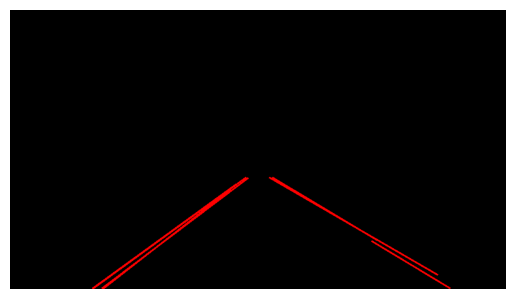

In [7]:
# perform hough transform on masked image to extract coordinates
# for lane lines

def hough_transform(masked_image, image_rgb):
    # Probabilistic Line Transform returns x_start, y_start, x_end,
    # and y_end coordinates
    linesP = cv2.HoughLinesP(masked_image, rho=1, theta=np.pi/180, threshold=50, 
                             minLineLength=100, maxLineGap=500)

    # make copy image to draw lines to
    line_image = np.zeros((image_rgb.shape[0], image_rgb.shape[1], 3), dtype=np.uint8)
    
    if linesP is not None:
        for i in range(len(linesP)):
            x1, y1, x2, y2 = linesP[i][0]
            # draw line on rgb image in red
            cv2.line(line_image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    return line_image

def weighted_image(image, initial_image):
    return cv2.addWeighted(initial_image, 0.8, image, 1., 0.)

# test hough_transform function on first canny test image
line_image = hough_transform(masked_img, image_rgb)
plt.imshow(line_image)
plt.axis("off")
plt.show()

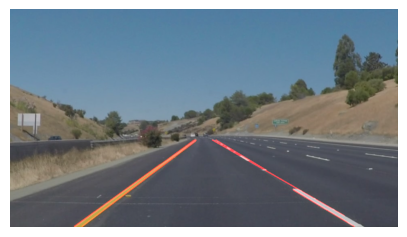

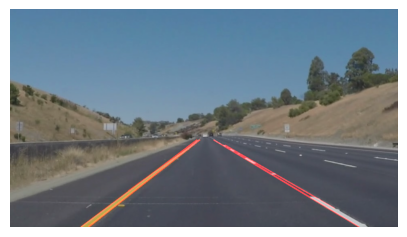

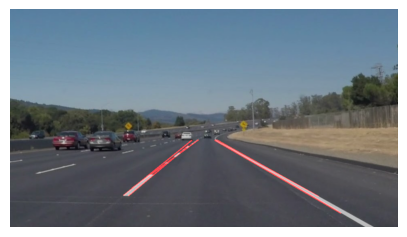

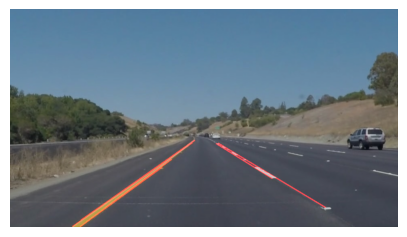

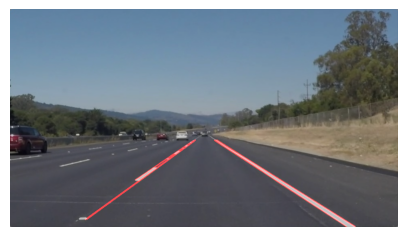

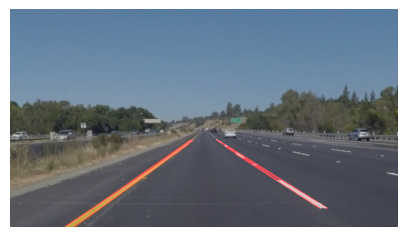

In [8]:
# define function to completely process image
def process_image(image_rgb):
    # grayscale image
    grayscale = to_grayscale(image_rgb)
    # reduce noise
    blur = gaussian_blur(grayscale)
    # canny edge detection
    edges = canny_edge(blur)
    # mask canny image
    masked_image, mask = mask_image(edges)
    # perform hough transform and draw lane lines on rgb image
    hough = hough_transform(masked_image, image_rgb)
    result = weighted_image(hough, image_rgb)
    return result

for image_name in test_images:
    image = cv2.imread(os.path.join(path, image_name))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    final_image = process_image(image_rgb)
    plt.figure(figsize=(5, 5))
    plt.axis("off")
    plt.imshow(final_image)
    plt.show()

In [9]:
# process videos frame by frame for real-time lane detection
from moviepy.editor import VideoFileClip

def process_video(test_video, output_video):
    clip = VideoFileClip(test_video, audio=False)
    processed_clip = clip.fl_image(process_image)
    processed_clip.write_videofile(output_video, audio=False)

test_video1 = "/kaggle/working/CarND-LaneLines-P1/test_videos/solidWhiteRight.mp4"
test_video2 = "/kaggle/working/CarND-LaneLines-P1/test_videos/solidYellowLeft.mp4"
output_video1 = "/kaggle/working/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4"
output_video2 = "/kaggle/working/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4"

process_video(test_video1, output_video1)
process_video(test_video2, output_video2)

error: XDG_RUNTIME_DIR not set in the environment.
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evalu

Moviepy - Building video /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4.
Moviepy - Writing video /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidWhiteRight.mp4
Moviepy - Building video /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4.
Moviepy - Writing video /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4



Moviepy - Done !
Moviepy - video ready /kaggle/working/CarND-LaneLines-P1/test_videos_output/solidYellowLeft.mp4
